# Multilayer Perceptron (MLP)

Autor: Jorge Vitor Gonçalves de Souza

Implementação de uma rede neural com múltiplas camadas com o objetivo de resolver a porta lógica XOR(OU Exclusivo). 

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import statistics

Para implementar o MLP foi necessário utilizar algumas funções de álgebra linear, pois a implementação feita utiliza uma notação de matriz para representar os neurônios e as camadas de neurônios da rede. Assim, foi implementado um método para calcular o produto escalar entre dois vetores, um método para multiplicar um vetor por um escalar(constante) e um método para realizar a soma de dois vetores.

In [2]:
# produto escalar de dois vetores
def dot(v, w):                                             
    if len(v) == len(w):
        return sum(v_i * w_i for v_i, w_i in zip(v, w))
    
# multiplica um vetor por um escalar
def scalar_multiply(c, v):                                 
    return [c * v_i for v_i in v]

# soma os elementos correspondentes de dois vetores
def add(v, w):                                            
    if len(v) == len(w):
        return [v_i + w_i for v_i, w_i in zip(v, w)]

A função de ativação dos neurônios escolhida foi a sigmoidal, pois a mesma possui uma aproximação suave e precisa.

In [3]:
# definição da função sigmoidal
def sigmoid(t):                                            
    return 1/(1 + np.exp(-t))

# calcula a saída de um neurônio
def neuron_output(weights, inputs):                        
    return sigmoid(dot(weights, inputs))

A função feed_forward calcula o valor de saída dos neurônios de todas as camadas da rede.

In [4]:
# retorna as saídas de todas as camadas
def feed_forward(neural_network, input_vector):            
    outputs = []
    # para cada camada da rede
    for layer in neural_network:
        # concatena o bias à entrada
        input_with_bias = input_vector + [1]
        # calcula a saída para cada neurônio na camada
        output = [neuron_output(neuron, input_with_bias)  
                  for neuron in layer]                    
        # adiciona ao vetor de saídas
        outputs.append(output)
        # a entrada da próxima camada é a saída da camada atual
        input_vector = output                              
    return outputs

Os sinais de entrada, $x_1, x_2, ..., x_m$ são propagados através da rede da esquerda para a direita(feed_forward), enquanto os sinais de erro, $e_1, e_2, ..., e_o$ são propagados da direita para a esquerda(backpropagation), ou seja, da camada de saída para a camada de entrada. A propagação dos sinais de erro inicia na camada de saída em direção á camada oculta. Na iteração de treinamento $p$, o sinal de erro na saída do neurônio $k$ é definido por:

$e_k(p) = y_Dk(p) − y_k(p)$, 

onde $y_Dk(p)$ é a saída desejada para o neurônio $k$ na iteração $p$. No caso da camada de saída, a correção em cada peso é similar à da regra Delta, aplicada no Perceptron 

$w_kj(p + 1) = w_kj(p) + ∆w_kj(p)$,

No caso do Perceptron, era usada a entrada do neurônio, $x_i$ , na correção do peso. Mas agora, na rede MLP, as entradas dos neurônios da camada de saída são diferentes das entradas da rede na camada inicial. Então, é empregada a saída do neurônio $j$, da camada oculta, ao invés da entrada $x_i$ 

$∆w_kj(p) = α.y_j(p).δ_k(p)$,

onde $δ_k(p)$ é o gradiente do erro cometido no neurônio $k$ da camada de saída na iteração de treinamento $p$. O gradiente do erro em um dado neurônio da camada de saída é definido como a derivada da função de ativação deste neurônio multiplicada pelo erro em sua saída 

$δ_k(p) = f′(X_k(p).e(p))$

Considerando uma função de ativação sigmoidal unipolar, tem-se

$y_k(p) = \frac {1}{1+e^-X_k(P)} ⇒ y′k(p) = y_k(p).(1 − y_k(p))$

e o gradiente se torna 

$δ_k(p) = y_k(p).(1 − y_k(p)).e(p)$

Considerando os neurônios da camada oculta também com funções de ativação sigmoidais unipolares, este gradiente do erro, correspondendo a um dado neurônio $j$ da camada oculta, é 

$δ_j(p) = y_j(p).(1 − y_j(p)). ∑δ_k(p).w_kj(p)$

Para o cálculo das correções nos pesos da camada oculta, é empregada a mesma equação da camada de saída 

$∆w_ji(p) = α.x_i(p).δ_j(p)$

In [5]:
def sqerror_gradient(network, input_vector, target_vector):
    
    # calcula as saídas de todos os neurônios
    hidden_outputs, outputs = feed_forward(network, input_vector) 
    
    # calcula os gradientes associados aos neurônios de saída
    output_deltas = [output * (1 - output) * (output - target)   
                     for output, target in zip(outputs, target_vector)]
    
    # correção dos pesos dos neurônios de saída
    output_grads = [[output_deltas[i] * hidden_output 
                     for hidden_output in hidden_outputs + [1]]
                     for i, output_neuron in enumerate(network[-1])]
    
    # calcula os gradientes associados aos neurônios das camadas ocultas
    hidden_deltas = [hidden_output * (1 - hidden_output) * 
                     dot(output_deltas, [n[i] for n in network[-1]]) 
                     for i, hidden_output in enumerate(hidden_outputs)]
    
    # correção dos pesos dos neurônios das camadas oculta
    hidden_grads = [[hidden_deltas[i] * input for input in input_vector + [1]] 
                    for i, hidden_neuron in enumerate(network[0])]
    
    return [hidden_grads, output_grads], output_deltas

A função gradient_step realiza um passo de um dado tamanho na direção do gradiente. Mais adiante será utilizada para retropropagar os erros a partir dos gradientes calculados.

In [6]:
# realiza um passo de um dado tamanho(step_size)
# na direção do gradiente(gradient) a partir de um vetor(v).
def gradient_step(v, gradient, step_size):                  
    if len(v) == len(gradient):                            
        step = scalar_multiply(step_size, gradient)
        return add(v, step)

Os pesos são inicializados de forma aleatória dentro do intervalo [-2, 2], e foi utilizada uma taxa de aprendizado de 0.9 em um intervalo de 10000 épocas.

In [7]:
# Entrada
X = [                                                      
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
]

# Saída desejada
Y = [                                                      
    [0],
    [1],
    [1],
    [0]
]

# Taxa de aprendizado
l_rate = 0.9                                               

epochs_con = []

for n in range(100):
    
    # backpropagation
    # inicialização aleatória dos pesos
    NN = [
        [[random.triangular(-0.5, 0.5, 0) for _ in range(2 + 1)],  
         [random.triangular(-0.5, 0.5, 0) for _ in range(2 + 1)]], 
        [[random.triangular(-0.5, 0.5, 0) for _ in range(2 + 1)]]  
    ]

    erro = []

    converged = False

    for epoch in range(10000):
        # para cada época a partir da camada de saída calcula os gradientes, 
        # atualiza os pesos e propaga os valores dos erros para as camadas anteriores 
            for x, y in zip(X, Y):                                   
                gradients, out_delta = sqerror_gradient(NN, x, y)
                NN = [[gradient_step(neuron, grad, -l_rate)               
                      for neuron, grad in zip(layer, layer_grad)]
                      for layer, layer_grad in zip(NN, gradients)]

            if converged == False:
                if(feed_forward(NN, X[0])[-1][0] < 0.1 
                   and feed_forward(NN, X[1])[-1][0] > 0.9 
                       and feed_forward(NN, X[2])[-1][0] > 0.9 
                           and feed_forward(NN, X[3])[-1][0] < 0.1):
                    epochs_con.append(epoch)
                    converged = True
        
            erro.append(out_delta)
        

Abaixo é possível conferir o gráfico do erro na camada de saída de acordo com o número de épocas.

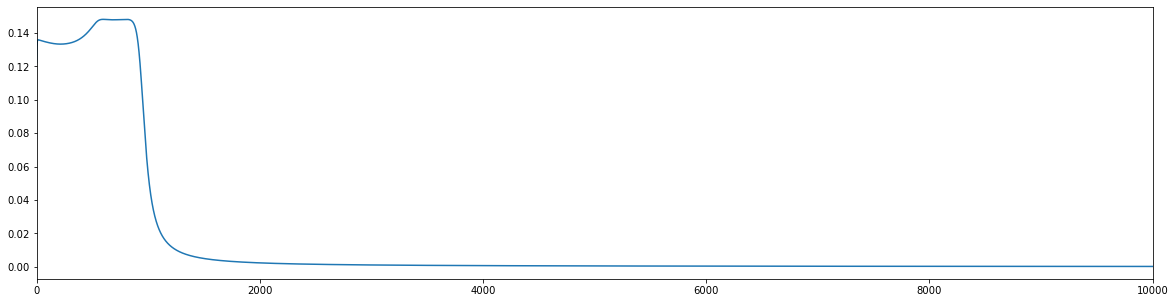

In [8]:
plt.figure(1, figsize=((20,5)))
plt.xlim(0, 10000)
plt.plot(erro)
plt.show()

Foi realizado um experimento onde o backpropagation foi executado 100 vezes, abaixo pode-se verificar os dados estatísticos do mesmo.

In [10]:
print("Taxa de Convergência:", len(epochs_con),"%")
print("Média de épocas para convergir:", statistics.mean(epochs_con))
print("Desvio Padrão:", statistics.stdev(epochs_con))

Taxa de Convergência: 81 %
Média de épocas para convergir: 1528.7407407407406
Desvio Padrão: 824.2714325053637
